## Null Pointers - Cluster Load Profiling Group Project ##

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
#Importing GaussianMixture to use its built-in BIC function.
from sklearn.mixture import GaussianMixture
from pandas import DataFrame
import warnings
warnings.filterwarnings('ignore')


## Reading Dataset ##

In [2]:

dfElectricalUsage = pd.read_csv('daily_electricity_usage.csv', index_col=1, parse_dates=True)
dfElectricalUsage


,Meter ID,total daily KW
date,,
2009-07-14,1000,11.203
2009-07-15,1000,8.403
2009-07-16,1000,7.225
2009-07-17,1000,11.338
2009-07-18,1000,11.306
2009-07-19,1000,2.874
2009-07-20,1000,11.600
2009-07-21,1000,4.610
2009-07-22,1000,12.436


## Cleaning data - Jorgen

In [3]:
#Dropping the costumers who are missing more than 100 dates
index = dfElectricalUsage.groupby('Meter ID').apply(len) >= 456
dfElectricalUsage = dfElectricalUsage.reset_index().set_index('Meter ID')[index]
dfElectricalUsage = dfElectricalUsage.reset_index().set_index('date')

In [4]:
period = pd.date_range(dfElectricalUsage.index.min(), dfElectricalUsage.index.max()) #Date range from first to last date.

"""
Grouping by Meter ID and applying the specified period to each consumer to fill the missing dates, while filling the missing 
values with the mean of the values for the given Meter ID.
"""
dfElectricalUsage = dfElectricalUsage.groupby('Meter ID').apply(lambda x: x.loc[period].fillna(x.mean()))

"""
The dataframe now has a MultiIndex with date and Meter ID. If we reset the index level it will try to insert Meter ID into
the dataframe. This causes a conflict since Meter ID already is a column. Therefore we drop the column before resetting.
"""
#If we reset index level, it will try to insert Meter ID
dfElectricalUsage = dfElectricalUsage.drop('Meter ID', axis = 1).reset_index(level = 0)
dfElectricalUsage.index.name = 'date'

In [5]:
#Test for null columns, if any
null_columns=dfElectricalUsage.columns[dfElectricalUsage.isnull().any()]
print(null_columns)
dfElectricalUsage[null_columns].isnull().sum()

print(dfElectricalUsage[dfElectricalUsage["total daily KW"].isnull()][null_columns])
print(dfElectricalUsage[dfElectricalUsage.index.isnull()][null_columns])

#Test any missing dates in the given time period
pd.date_range(start = '2009-07-14', end = '2010-10-17' ).difference(dfElectricalUsage.index)

Index([], dtype='object')
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []


DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [6]:
df = dfElectricalUsage.groupby('Meter ID').nunique()
print("Total # of consumers", df.count())

Total # of consumers Meter ID          5923
total daily KW    5923
dtype: int64


## Adding calender features to dataset - Anju ##

In [7]:
from datetime import date
import calendar
my_date = date.today()
calendar.day_name[my_date.weekday()]

'Tuesday'

In [8]:
column_1 = dfElectricalUsage.iloc[:,0]
column_1
#Tried using next line since index_col was changed to 'date'.
#column_1 = dfElectricalUsage.reset_index().set_index('Meter ID').iloc[:,0]
dfElectricalUsage

dfElectricalUsage = pd.DataFrame({"date":dfElectricalUsage.index,
                               "year": dfElectricalUsage.index.year,
                               "month": dfElectricalUsage.index.month,
                               "day": dfElectricalUsage.index.day,
                               "dayofyear": dfElectricalUsage.index.dayofyear,
                               "weekofyear": dfElectricalUsage.index.weekofyear,
                               "weekday": dfElectricalUsage.index.weekday,
                               "weekend": ((pd.DatetimeIndex(dfElectricalUsage.index).dayofweek) // 5 == 1).astype(int),   #integer division to get the weekends
                               "quarter": dfElectricalUsage.index.quarter,
                               "DailyUsage": dfElectricalUsage['total daily KW'],
                               "Meter ID": dfElectricalUsage['Meter ID']})

print(dfElectricalUsage)

                 date  year  month  day  dayofyear  weekofyear  weekday  \
date                                                                      
2009-07-14 2009-07-14  2009      7   14        195          29        1   
2009-07-15 2009-07-15  2009      7   15        196          29        2   
2009-07-16 2009-07-16  2009      7   16        197          29        3   
2009-07-17 2009-07-17  2009      7   17        198          29        4   
2009-07-18 2009-07-18  2009      7   18        199          29        5   
2009-07-19 2009-07-19  2009      7   19        200          29        6   
2009-07-20 2009-07-20  2009      7   20        201          30        0   
2009-07-21 2009-07-21  2009      7   21        202          30        1   
2009-07-22 2009-07-22  2009      7   22        203          30        2   
2009-07-23 2009-07-23  2009      7   23        204          30        3   
2009-07-24 2009-07-24  2009      7   24        205          30        4   
2009-07-25 2009-07-25  20

In [9]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
holidays = cal.holidays(start='2009-07-14', end='2010-10-17')
dfElectricalUsage['Holiday'] = dfElectricalUsage.index.isin(holidays)
dfElectricalUsageOnlyHoliday = dfElectricalUsage[dfElectricalUsage['Holiday']== True]
print(dfElectricalUsageOnlyHoliday)

                 date  year  month  day  dayofyear  weekofyear  weekday  \
date                                                                      
2009-09-07 2009-09-07  2009      9    7        250          37        0   
2009-10-12 2009-10-12  2009     10   12        285          42        0   
2009-11-11 2009-11-11  2009     11   11        315          46        2   
2009-11-26 2009-11-26  2009     11   26        330          48        3   
2009-12-25 2009-12-25  2009     12   25        359          52        4   
2010-01-01 2010-01-01  2010      1    1          1          53        4   
2010-01-18 2010-01-18  2010      1   18         18           3        0   
2010-02-15 2010-02-15  2010      2   15         46           7        0   
2010-05-31 2010-05-31  2010      5   31        151          22        0   
2010-07-05 2010-07-05  2010      7    5        186          27        0   
2010-09-06 2010-09-06  2010      9    6        249          36        0   
2010-10-11 2010-10-11  20

## Adding Statistical features : Anil , Anju , Jorgen , Shiela##
### Weekday percentage , Monthly Average per user: Jorgen ###
### Quarterly Average per user , Weekday Average per user, Daily Average per user: Anju , Shiela
### Weekend Average, Total consumption per user : Anil 


In [10]:
#Weekday percentage usage.
weekdaysums = dfElectricalUsage.groupby(['Meter ID','weekday'])['DailyUsage'].sum()
dfUserGroup5 = (weekdaysums / dfElectricalUsage.groupby(['Meter ID'])['DailyUsage'].sum() * 100).reset_index(name='weekdayPerc')
dfUserGroup5 = dfUserGroup5.pivot(index = 'Meter ID', columns = 'weekday')['weekdayPerc'].reset_index()
weekday_perc_cols = ['Meter ID', 'monPerc', 'tuePerc', 'wedPerc', 'thursPerc','friPerc','satPerc','sunPerc']
dfUserGroup5.columns = weekday_perc_cols

In [11]:
#daily Average per user
print(dfElectricalUsage.head())
dfUserGroupTotalConsumption = dfElectricalUsage.groupby('Meter ID')['DailyUsage'].sum().reset_index(name='Total KW')

#daily Average per user
print(dfElectricalUsage.head())
dfUserGroup = dfElectricalUsage.groupby('Meter ID')['DailyUsage'].mean().reset_index(name='DailyAvgPerUser')

#Quarterly Average per user
qtly_avg_cols = ['Meter ID', 'Q1Avg', 'Q2Avg', 'Q3Avg', 'Q4Avg']
dfUserGroup2 = dfElectricalUsage.groupby(['Meter ID','quarter'])['DailyUsage'].mean().reset_index(name='qtlylyAvg')
dfUserGroup2 = dfUserGroup2.pivot(index = 'Meter ID', columns = 'quarter')['qtlylyAvg'].reset_index()
dfUserGroup2.columns = qtly_avg_cols

# Weekday Average per user
weekday_avg_cols = ['Meter ID', 'MonAvg', 'TueAvg', 'WedAvg', 'ThursAvg','FriAvg','SatAvg','SunAvg']
dfUserGroup3 = dfElectricalUsage.groupby(['Meter ID','weekday'])['DailyUsage'].mean().reset_index(name='weekdayAvg')
dfUserGroup3 = dfUserGroup3.pivot(index = 'Meter ID', columns = 'weekday')['weekdayAvg'].reset_index()
dfUserGroup3.columns = weekday_avg_cols

#Monthly average per user
month_avg_cols = ['Meter ID', 'janAvg', 'febAvg', 'marAvg', 'aprAvg', 'mayAvg', 'junAvg', 'julAvg', 'augAvg', 'sepAvg', 'octAvg', 'novAvg', 'desAvg']
dfUserGroup4 = dfElectricalUsage.groupby(['Meter ID', 'month'])['DailyUsage'].mean().reset_index(name='monthlyAverage')
dfUserGroup4 = dfUserGroup4.pivot(index = 'Meter ID', columns = 'month')['monthlyAverage'].reset_index()
dfUserGroup4.columns = month_avg_cols

#Weekend average
dfElectricalUsage['weekend'] = dfElectricalUsage['weekend'].map( lambda x : 1 if x == 0 else x)
dfWeekendAverage = dfElectricalUsage.groupby(['Meter ID','weekend'])['DailyUsage'].mean().reset_index(name='weekendAvg')
dfWeekendAverage = dfWeekendAverage.drop('weekend', 1)

# Merging groups to one dataframe

dfElectricityUsage0 = pd.merge(dfUserGroupTotalConsumption,dfUserGroup,on='Meter ID')
dfElectricityUsage1 = pd.merge(dfElectricityUsage0,dfUserGroup2,on='Meter ID')
dfElectricityUsage2 = pd.merge(dfElectricityUsage1,dfUserGroup3,on='Meter ID')
dfElectricityUsage3 = pd.merge(dfElectricityUsage2,dfUserGroup4,on='Meter ID')
dfElectricityUsage = pd.merge(dfElectricityUsage3,dfWeekendAverage,on='Meter ID')

dfElectricityUsage


                 date  year  month  day  dayofyear  weekofyear  weekday  \
date                                                                      
2009-07-14 2009-07-14  2009      7   14        195          29        1   
2009-07-15 2009-07-15  2009      7   15        196          29        2   
2009-07-16 2009-07-16  2009      7   16        197          29        3   
2009-07-17 2009-07-17  2009      7   17        198          29        4   
2009-07-18 2009-07-18  2009      7   18        199          29        5   

            weekend  quarter  DailyUsage  Meter ID  Holiday  
date                                                         
2009-07-14        0        3      11.203      1000    False  
2009-07-15        0        3       8.403      1000    False  
2009-07-16        0        3       7.225      1000    False  
2009-07-17        0        3      11.338      1000    False  
2009-07-18        1        3      11.306      1000    False  
                 date  year  month  day 

,Meter ID,Total KW,DailyAvgPerUser,Q1Avg,Q2Avg,Q3Avg,Q4Avg,MonAvg,TueAvg,WedAvg,...,aprAvg,mayAvg,junAvg,julAvg,augAvg,sepAvg,octAvg,novAvg,desAvg,weekendAvg
0,1000,5515.675000,10.290438,12.184656,7.886923,8.704567,12.026440,10.029066,10.493675,10.596247,...,8.411233,7.646516,7.611033,8.431796,8.774016,8.855567,10.584613,11.252267,14.217468,10.290438
1,1001,5090.375000,9.496968,6.740656,4.393681,5.030871,17.519630,9.461461,9.494429,9.446922,...,5.030867,4.091355,4.068900,5.050061,4.959355,5.089100,5.178452,11.673000,35.518839,9.496968
2,1002,5352.830000,9.986623,11.041756,9.663022,9.457491,10.122315,11.068092,10.070377,11.133766,...,8.100100,10.225839,10.644367,9.943857,9.244500,9.280383,8.675387,11.422967,10.310548,9.986623
3,1003,16305.581000,30.420860,34.442156,29.878198,26.478684,32.385957,31.205987,29.749117,30.104987,...,32.629533,32.622774,24.290800,26.464633,25.851242,27.138517,29.507403,32.247150,35.398839,30.420860
4,1004,25326.442000,47.250825,45.986500,41.709725,48.071123,49.847337,48.756053,46.630390,47.364740,...,37.611300,45.338000,42.058933,45.918694,47.645984,50.268250,48.738435,49.455483,51.335452,47.250825
5,1005,16062.905000,29.968106,39.393122,22.774330,22.066216,36.259440,29.647855,30.446221,30.518545,...,21.622033,23.676968,22.993900,22.216592,20.610516,23.447633,27.614290,37.748383,43.463677,29.968106
6,1006,11518.920000,21.490522,29.277178,12.955681,15.665778,27.316082,22.084829,21.356779,20.089506,...,17.202033,15.096097,6.497567,14.505694,15.255452,17.037183,21.187419,25.486700,35.215113,21.490522
7,1007,18745.140277,34.972277,39.328789,35.156824,31.545749,35.934540,33.781329,32.209870,33.279325,...,33.964867,34.925968,36.587333,28.262041,34.448919,31.227500,31.855887,36.185800,39.770037,34.972277
8,1008,18843.172172,35.155172,41.770378,30.745473,28.936544,39.879626,34.853908,36.030545,34.398909,...,34.497233,29.669387,28.105667,28.417388,28.201677,30.119883,34.076661,38.891633,46.638712,35.155172
9,1009,21498.187000,40.108558,41.688656,29.571176,37.983398,46.522120,37.402803,39.876870,39.290675,...,30.650067,28.860161,29.227000,34.060245,38.973952,40.163733,43.952226,46.779183,48.843242,40.108558


## K-Means Clustering :   Anil,Jorgen , ##
### Anil  : Kmean clustering
### Jorgen : Choosing number of clusters - BIC and Elbow


In [12]:
import matplotlib.pyplot as plt  
%matplotlib inline
import numpy as np  
from sklearn.cluster import KMeans  

In [13]:
dfElectricityUsage = dfElectricityUsage.round(3)
averages = dfElectricityUsage.iloc[:,1:].values

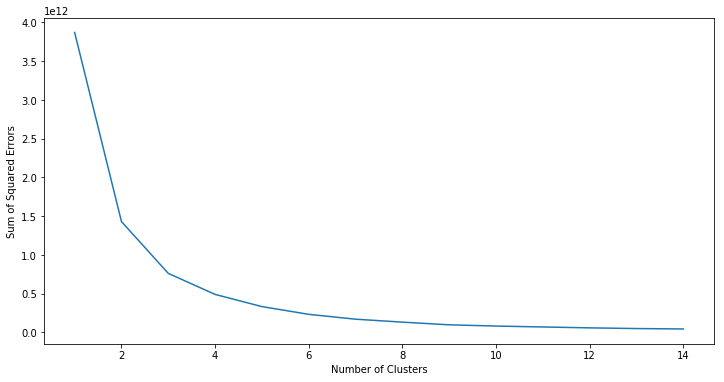

In [14]:
features = averages #Extracting the features from the dataset.
SSE = {}
for k in range(1, 15):
    model = KMeans(n_clusters = k).fit(features) #Creating the model and fitting it with feature data.
    SSE[k] = model.inertia_

#Plotting with the sum of squared errors on the y-axis, and the number of clusters on the x-axis.
plt.figure(figsize = (12,6))
plt.plot(list(SSE.keys()), list(SSE.values()))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Errors")
plt.show()


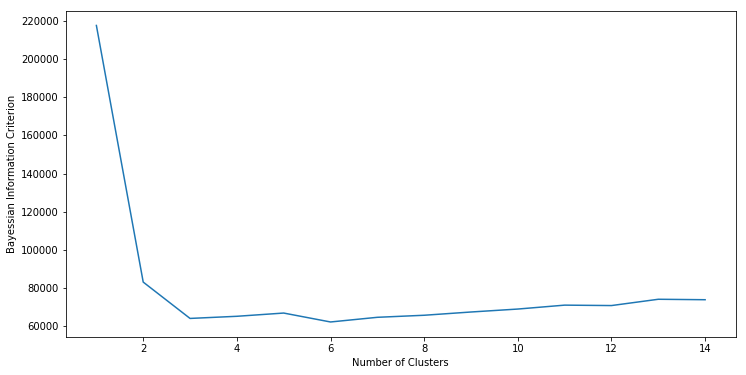

In [15]:
BIC = {}

for k in range(1, 15):
    model = GaussianMixture(n_components = k, init_params = 'kmeans').fit(features)
    BIC[k] = model.bic(features)

plt.figure(figsize = (12,6))
plt.plot(list(BIC.keys()), list(BIC.values()))
plt.xlabel("Number of Clusters")
plt.ylabel("Bayessian Information Criterion")
plt.show()

In [16]:
from sklearn.preprocessing import StandardScaler
x_calls = dfElectricityUsage.columns[1:]
scaller = StandardScaler()
matrix = pd.DataFrame(scaller.fit_transform(dfElectricityUsage[x_calls]),columns=x_calls)
matrix['Meter ID'] = dfElectricityUsage['Meter ID']
print(matrix.head())

   Total KW  DailyAvgPerUser     Q1Avg     Q2Avg     Q3Avg     Q4Avg  \
0 -0.476242        -0.476251 -0.468600 -0.467837 -0.444752 -0.487717   
1 -0.492878        -0.492878 -0.570166 -0.543784 -0.523941 -0.376364   
2 -0.482612        -0.482604 -0.489924 -0.429222 -0.428544 -0.526308   
3 -0.054171        -0.054168 -0.053362  0.010306 -0.061653 -0.075057   
4  0.298700         0.298704  0.162028  0.267566  0.403740  0.278846   

     MonAvg    TueAvg    WedAvg  ThursAvg    ...       mayAvg    junAvg  \
0 -0.474735 -0.458322 -0.453305 -0.469686    ...    -0.475387 -0.441240   
1 -0.486337 -0.477932 -0.475911 -0.460891    ...    -0.553856 -0.517019   
2 -0.453513 -0.466637 -0.442720 -0.443629    ...    -0.418478 -0.376351   
3 -0.042179 -0.080729 -0.069477 -0.060556    ...     0.075745 -0.084381   
4  0.316293  0.250310  0.270104  0.220272    ...     0.356321  0.295754   

     julAvg    augAvg    sepAvg    octAvg    novAvg    desAvg  weekendAvg  \
0 -0.429440 -0.437678 -0.460817 -0.4571

In [19]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
cluster = KMeans(n_clusters=5,random_state=217)
matrix['cluster'] = cluster.fit_predict(matrix[x_calls])
print(matrix.cluster.value_counts())

0    3635
4    1984
3     205
2      82
1      17
Name: cluster, dtype: int64


Text(0.5,1,'Cluster of Data')

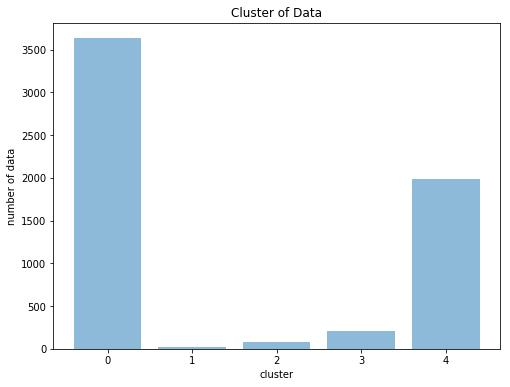

In [20]:
d=pd.DataFrame(matrix.cluster.value_counts())
fig, ax = plt.subplots(figsize=(8, 6))
plt.bar(d.index,d['cluster'],align='center',alpha=0.5)
plt.xlabel('cluster')
plt.ylabel('number of data')
plt.title('Cluster of Data')

In [21]:
from sklearn.metrics.pairwise import euclidean_distances
distance = euclidean_distances(cluster.cluster_centers_, cluster.cluster_centers_)
print(distance)

[[ 0.         62.62111549 25.68331609 10.14756748  2.21616101]
 [62.62111549  0.         37.19870328 52.61996813 60.42241755]
 [25.68331609 37.19870328  0.         15.55507597 23.4746664 ]
 [10.14756748 52.61996813 15.55507597  0.          7.94599644]
 [ 2.21616101 60.42241755 23.4746664   7.94599644  0.        ]]


In [22]:
# Reduction dimention of the data using PCA
pca = PCA(n_components=3)
matrix['x'] = pca.fit_transform(matrix[x_calls])[:,0]
matrix['y'] = pca.fit_transform(matrix[x_calls])[:,1]
matrix['z'] = pca.fit_transform(matrix[x_calls])[:,2]


In [23]:
# Getting the center of each cluster for plotting
cluster_centers = pca.transform(cluster.cluster_centers_)

cluster_centers = pd.DataFrame(cluster_centers, columns=['x', 'y', 'z'])
cluster_centers['cluster'] = range(0, len(cluster_centers))
print(cluster_centers)

           x         y         z  cluster
0  -1.622147 -0.073157 -0.034210        0
1  60.879786 -3.854198  0.657627        1
2  24.031273  1.110134 -0.379464        2
3   8.479947  0.846937 -0.290651        3
4   0.586511  0.033936  0.103105        4


Text(0.5,1,'Data Segmentation')

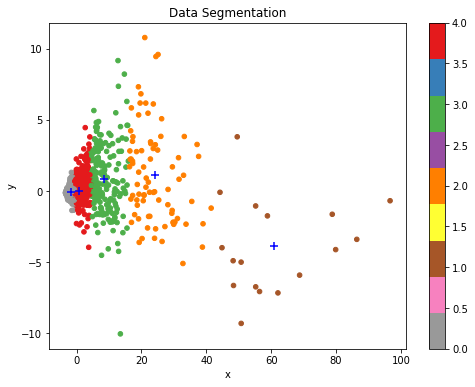

In [24]:
# Plotting for 2-dimension
fig, ax = plt.subplots(figsize=(8, 6))
scatter=ax.scatter(matrix['x'],matrix['y'],c=matrix['cluster'],s=21,cmap=plt.cm.Set1_r)
ax.scatter(cluster_centers['x'],cluster_centers['y'],s=70,c='blue',marker='+')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(scatter)
plt.title('Data Segmentation')

In [25]:
dfElectricityUsage['cluster']=matrix['cluster']
print(dfElectricityUsage[dfElectricityUsage.columns[1:]].groupby(['cluster']).agg([np.mean]))

              Total KW DailyAvgPerUser       Q1Avg       Q2Avg       Q3Avg  \
                  mean            mean        mean        mean        mean   
cluster                                                                      
0          9381.131134       17.502113   19.361021   15.265486   15.638638   
1        328764.446000      613.366529  611.222588  611.122235  625.651941   
2        140574.377671      262.265646  304.203232  240.460890  235.211451   
3         60939.283502      113.692693  139.992780  102.066366   96.907205   
4         20701.231266       38.621701   43.613816   34.092379   33.841418   

              Q4Avg      MonAvg      TueAvg      WedAvg    ThursAvg  \
               mean        mean        mean        mean        mean   
cluster                                                               
0         19.430839   17.444401   17.420202   17.263180   17.125671   
1        604.107471  604.582294  628.992176  628.615294  644.773647   
2        277.679207 

{Cluster 0} has got highest number of consumers i.e. 3635 which is about 61\% of total consumers. Total daily consumption of this cluster is about 9381 Kwh and the daily average consumption is the lowest among all the clusters. Having so many consumers yet consuming less consumption leads us to think that cluster 0 is either a rural area or it mostly consists of normal households with not too high consumption per day.

{Cluster 1} has the least number of consumers i.e. 17 yet it has the highest consumption of all with a daily average consumption of 613Kwh and Total consumption stands at 328764kwh. Quarterly average consumption is almost the same for all 4 quarters. This cluster could possibly consists of heavy industries or manufacturing units where electricity consumption is considerably higher relative to other clusters.  

{Cluster 2} has second highest consumption with not so many consumers i.e. 82 yet it has second highest consumption. Electricity consumption pattern for Cluster 2 looks similar to that of Cluster 0 but overall consumption is 1/3rd. This again looks like an industrial zone where small scale industries(more than cluster 0) might have been functional.

{Cluster 3} has got 205 consumer which has an average daily consumption of 113Kwh where electricity consumption is generally high during start and end of a quarter. 

{Cluster 4} has got second highest number of consumers i.e. 1984. Considering the number of consumers, consumption is fairly low but we see a seasonal pattern i.e. consumption increases during the months of Jan-feb and nov-dec. These could likely be winter months. Also, this again looks like a community of normal households where consumption is generally within an estimated range.


In [26]:
list(dfElectricityUsage[dfElectricityUsage.cluster==0]['Meter ID'])

[1000,
 1001,
 1002,
 1006,
 1013,
 1015,
 1016,
 1017,
 1021,
 1022,
 1024,
 1025,
 1027,
 1029,
 1030,
 1032,
 1036,
 1037,
 1041,
 1043,
 1045,
 1046,
 1047,
 1052,
 1053,
 1054,
 1055,
 1058,
 1060,
 1061,
 1062,
 1063,
 1065,
 1067,
 1069,
 1071,
 1072,
 1074,
 1075,
 1076,
 1077,
 1078,
 1080,
 1081,
 1082,
 1083,
 1084,
 1085,
 1086,
 1087,
 1092,
 1093,
 1095,
 1098,
 1099,
 1100,
 1101,
 1102,
 1107,
 1110,
 1111,
 1112,
 1113,
 1115,
 1118,
 1120,
 1121,
 1122,
 1123,
 1124,
 1126,
 1127,
 1132,
 1133,
 1136,
 1144,
 1147,
 1148,
 1149,
 1150,
 1152,
 1153,
 1156,
 1159,
 1161,
 1162,
 1165,
 1166,
 1170,
 1174,
 1178,
 1179,
 1180,
 1183,
 1184,
 1185,
 1189,
 1192,
 1195,
 1197,
 1198,
 1199,
 1201,
 1204,
 1205,
 1207,
 1208,
 1209,
 1210,
 1212,
 1213,
 1214,
 1215,
 1216,
 1218,
 1219,
 1220,
 1221,
 1222,
 1223,
 1224,
 1225,
 1226,
 1230,
 1231,
 1232,
 1234,
 1235,
 1236,
 1239,
 1241,
 1243,
 1244,
 1247,
 1248,
 1249,
 1250,
 1252,
 1255,
 1257,
 1259,
 1260,
 1262,

## Hierarchical clustering - Shiela ##

In [27]:
from scipy.cluster.hierarchy import dendrogram, linkage


In [28]:
feature1 = dfElectricityUsage.iloc[:,1:]
feature1

,Total KW,DailyAvgPerUser,Q1Avg,Q2Avg,Q3Avg,Q4Avg,MonAvg,TueAvg,WedAvg,ThursAvg,...,mayAvg,junAvg,julAvg,augAvg,sepAvg,octAvg,novAvg,desAvg,weekendAvg,cluster
0,5515.675,10.290,12.185,7.887,8.705,12.026,10.029,10.494,10.596,9.204,...,7.647,7.611,8.432,8.774,8.856,10.585,11.252,14.217,10.290,0
1,5090.375,9.497,6.741,4.394,5.031,17.520,9.461,9.494,9.447,9.660,...,4.091,4.069,5.050,4.959,5.089,5.178,11.673,35.519,9.497,0
2,5352.830,9.987,11.042,9.663,9.457,10.122,11.068,10.070,11.134,10.555,...,10.226,10.644,9.944,9.245,9.280,8.675,11.423,10.311,9.987,0
3,16305.581,30.421,34.442,29.878,26.479,32.386,31.206,29.749,30.105,30.416,...,32.623,24.291,26.465,25.851,27.139,29.507,32.247,35.399,30.421,4
4,25326.442,47.251,45.987,41.710,48.071,49.847,48.756,46.630,47.365,44.976,...,45.338,42.059,45.919,47.646,50.268,48.738,49.455,51.335,47.251,4
5,16062.905,29.968,39.393,22.774,22.066,36.259,29.648,30.446,30.519,28.193,...,23.677,22.994,22.217,20.611,23.448,27.614,37.748,43.464,29.968,4
6,11518.920,21.491,29.277,12.956,15.666,27.316,22.085,21.357,20.090,21.062,...,15.096,6.498,14.506,15.255,17.037,21.187,25.487,35.215,21.491,0
7,18745.140,34.972,39.329,35.157,31.546,35.935,33.781,32.210,33.279,33.291,...,34.926,36.587,28.262,34.449,31.227,31.856,36.186,39.770,34.972,4
8,18843.172,35.155,41.770,30.745,28.937,39.880,34.854,36.031,34.399,32.707,...,29.669,28.106,28.417,28.202,30.120,34.077,38.892,46.639,35.155,4
9,21498.187,40.109,41.689,29.571,37.983,46.522,37.403,39.877,39.291,40.590,...,28.860,29.227,34.060,38.974,40.164,43.952,46.779,48.843,40.109,4


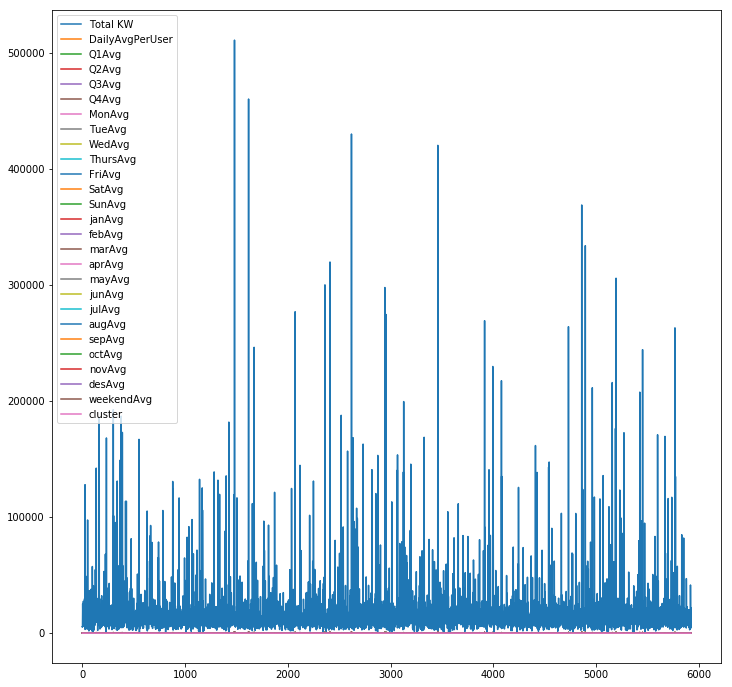

In [29]:
feature1.plot(figsize=(12,12))

In [30]:
Z= linkage(feature1, 'ward')


**'ward' is one of the methods that can be used to calculate the distance between newly formed clusters.
The keyword ‘ward’ causes linkage function to use the Ward variance minimization algorithm.
Other common linkage methods like single, complete, average, and different distance metrics such as euclidean, manhattan, hamming, cosine are also available if you want to play around with.

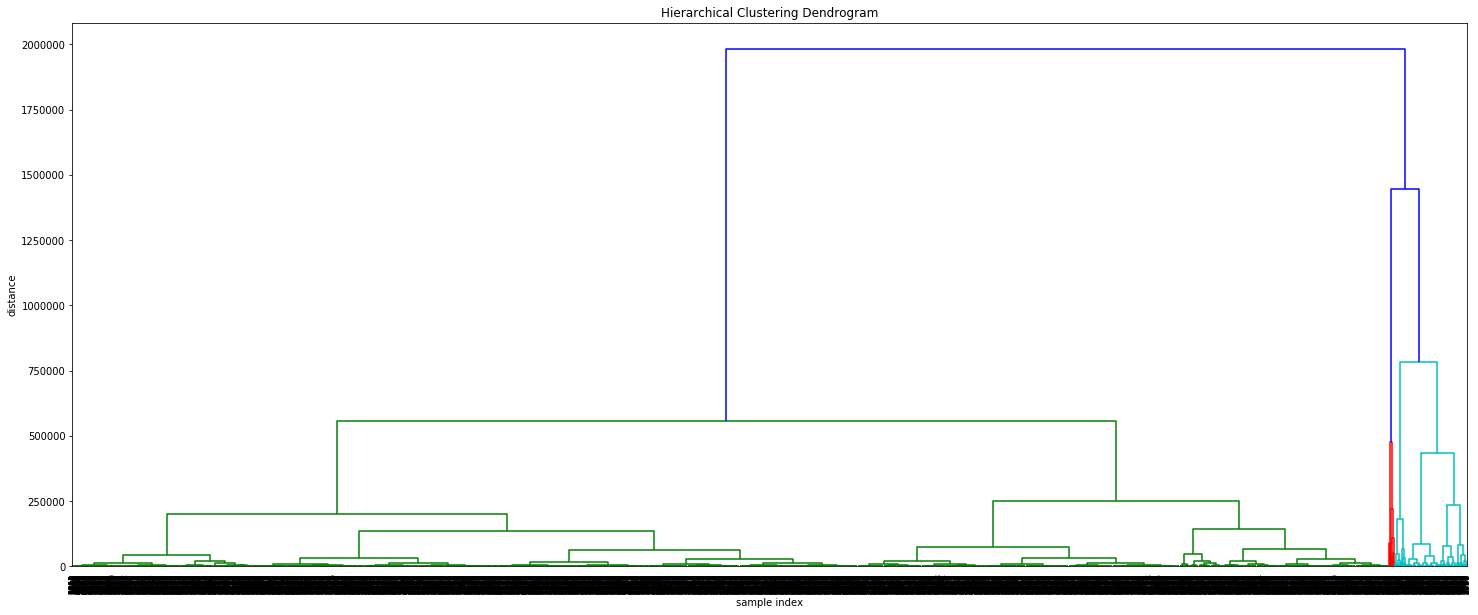

In [31]:
plt.figure(figsize=(25,10))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,
    leaf_font_size=8.,
)
plt.show()

In [32]:
#Retreiving the Clusters using fcluster function
from scipy.cluster.hierarchy import fcluster

def print_clusters(feature1, Z, k, plot=False):
    # k Number of clusters I'd like to extract
    results = fcluster(Z, k, criterion='maxclust')

    # check the results
    s = pd.Series(results)
    clusters = s.unique()

    for c in clusters:
        cluster_indeces = s[s==c].index
        print("Cluster %d number of consumers %d" % (c, len(cluster_indeces)))
        if plot:
            feature1.T.iloc[:,cluster_indeces].plot()
            plt.show()

print_clusters(feature1, Z, 9, plot=False)

Cluster 1 number of consumers 3334
Cluster 2 number of consumers 1367
Cluster 3 number of consumers 891
Cluster 6 number of consumers 48
Cluster 7 number of consumers 143
Cluster 9 number of consumers 47
Cluster 8 number of consumers 71
Cluster 4 number of consumers 4
Cluster 5 number of consumers 18


## Preparing data for use in Prediction  - Anju ##

In [35]:
dfNew = dfElectricityUsage
dfElectricityUsage.set_index('Meter ID')
dfElectricalUsage.set_index('Meter ID')
# Merging our original dataset to the processed one , so that we get all features and cluster for the Meter ID
dfNew =dfElectricalUsage.merge(dfElectricityUsage , how ='outer', on = 'Meter ID')

#making seperate dataframe for each cluster with Daily usage and date only
col_list = ['date','DailyUsage']
dfUserGroupClus1 = dfNew[(dfNew['cluster']==0)]
dfUserGroupClus1 = dfUserGroupClus1[col_list]
dfUserGroupClus1.columns=['ds','y']
dfUserGroupClus2 = dfNew[(dfNew['cluster']==1)]
dfUserGroupClus2 = dfUserGroupClus2[col_list]
dfUserGroupClus2.columns=['ds','y']
dfUserGroupClus3 = dfNew[(dfNew['cluster']==2)]
dfUserGroupClus3 = dfUserGroupClus3[col_list]
dfUserGroupClus3.columns=['ds','y']
dfUserGroupClus4 = dfNew[(dfNew['cluster']==3)]
dfUserGroupClus4 = dfUserGroupClus4[col_list]
dfUserGroupClus4.columns=['ds','y']
dfUserGroupClus5 = dfNew[(dfNew['cluster']==4)]
dfUserGroupClus5 = dfUserGroupClus5[col_list]
dfUserGroupClus5.columns=['ds','y']



In [36]:
#making seperate dataframe for each cluster with Total daily KW usage for a cluster and date only
dfCluster1 = dfUserGroupClus1.groupby(['ds'])['y'].sum().reset_index()
dfCluster2 = dfUserGroupClus2.groupby(['ds'])['y'].sum().reset_index()
dfCluster3 = dfUserGroupClus3.groupby(['ds'])['y'].sum().reset_index()
dfCluster4 = dfUserGroupClus4.groupby(['ds'])['y'].sum().reset_index()
dfCluster5 = dfUserGroupClus5.groupby(['ds'])['y'].sum().reset_index()

In [37]:
def plot_data(data_cluster):
    plotDf=data_cluster.copy()
    plotDf.columns=['date','Total Daily KW']
    plotDf = plotDf.set_index('date') 
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.scatter(plotDf.index,plotDf['Total Daily KW'],c='black',s=7)

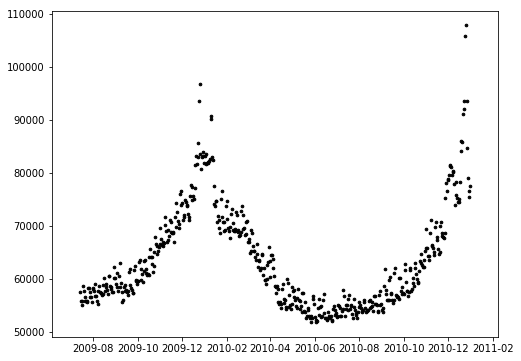

In [38]:
plot_data(dfCluster1)

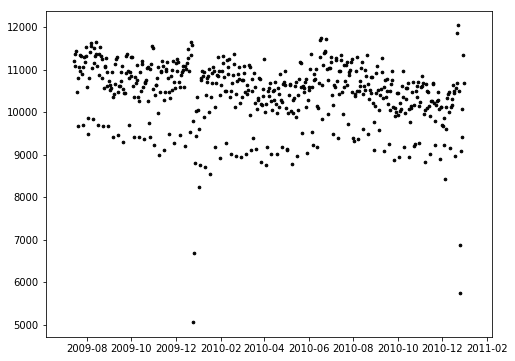

In [39]:
plot_data(dfCluster2)

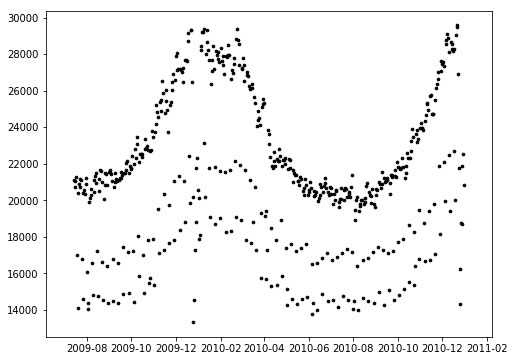

In [40]:
plot_data(dfCluster3)

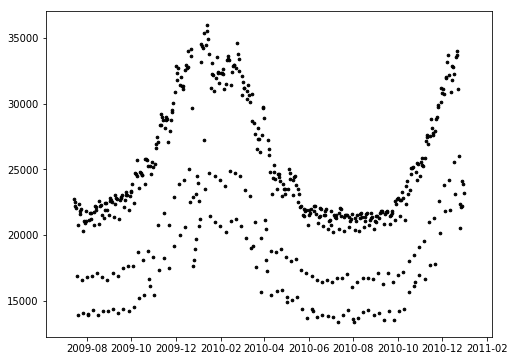

In [41]:
plot_data(dfCluster4)

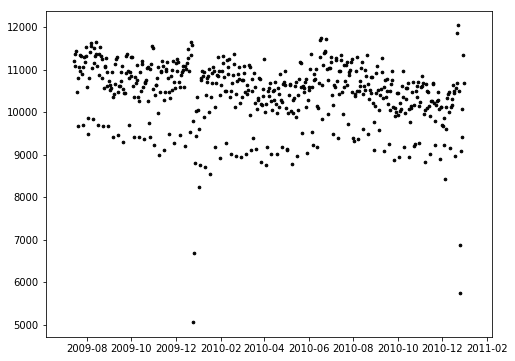

In [42]:
plot_data(dfCluster2)

## FBProphet Time Series Prediction - Anju ##

In [43]:
import fbprophet
from sklearn.metrics import mean_squared_error, r2_score

In [44]:
def timeseriesPredictFbProphet(train,test):
    model = fbprophet.Prophet(daily_seasonality=False,weekly_seasonality=True,
                yearly_seasonality=True,changepoint_prior_scale=0.05,changepoints=None,interval_width=0.95)
    model.add_seasonality(name='monthly',period=30.5,fourier_order=5)
    model.fit(train)
    fbPredictions=model.predict(test)
    testset=test.set_index('ds')
    testPredictMerged=pd.merge(test,fbPredictions[['ds','yhat','yhat_lower','yhat_upper']],how='left',on='ds')
    
    # Print out the Root mean squared error (RMSE)
    RMSE=np.sqrt(mean_squared_error(testPredictMerged['y'], testPredictMerged['yhat']))
    print('RMSE = %.2f' % RMSE)
   

    # Print out the mean absolute error (mae)
    errors = abs(testPredictMerged['yhat'])- abs(testPredictMerged['y'])
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
    
    #predicting future 90 days
    futuredf = model.make_future_dataframe(periods=90, freq='D')
    futuredf=model.predict(futuredf)
    
    # Plotting
    fig=model.plot(fbPredictions)
    fig2=model.plot(futuredf)
    plt.scatter(testset.index,testset['y'],c='Red',s=7)
    fig3=model.plot_components(futuredf)

### Cluster 1 Prediction of last 80 days Total daily consumption of cluster  and forecasting for 3 month ahead ##

In [45]:
# This is to make last 80 days as test dataset and rest as train dataset 
size = len(dfCluster1) - 80
train1, test1 = dfCluster1[0:size], dfCluster1[size:]

RMSE = 6124.75
Mean Absolute Error: -2672.65 degrees.


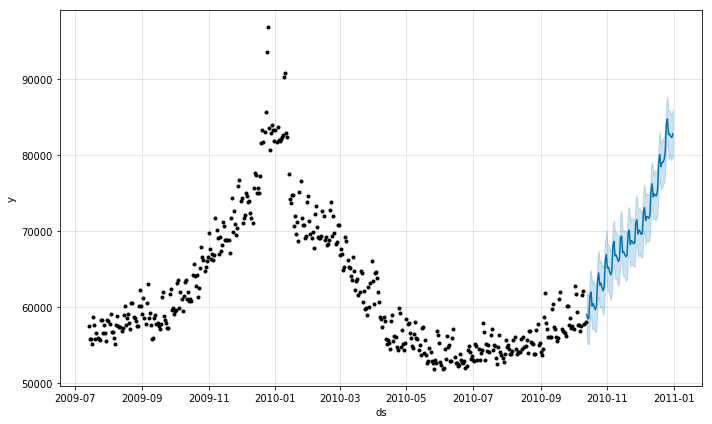

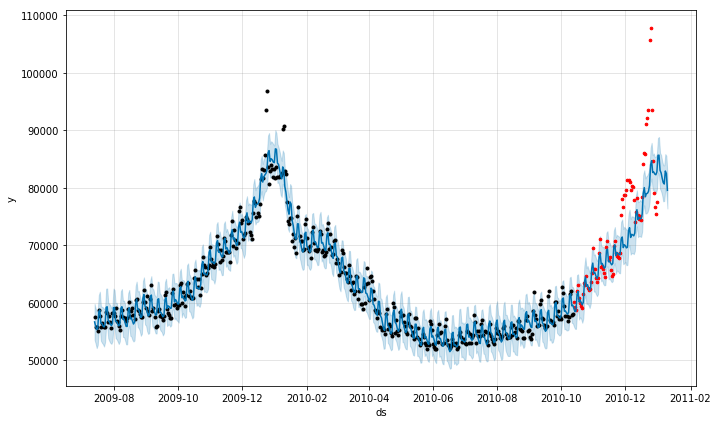

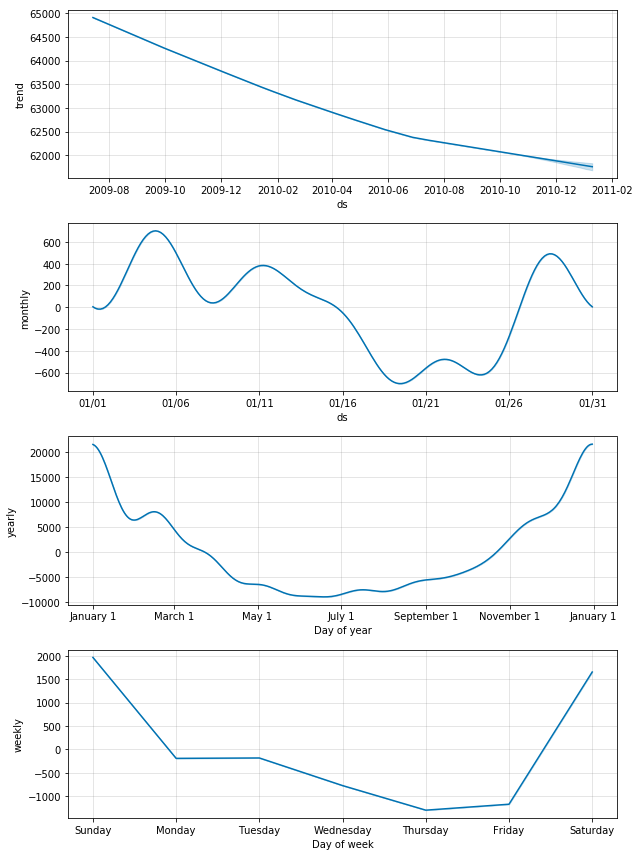

In [46]:
timeseriesPredictFbProphet(train1,test1)

### Cluster 2 Prediction of last 80 days Total daily consumption of cluster  and forecasting for 3 month ahead ##


In [47]:
# This is to make last 80 days as test dataset and rest as train dataset 
size = len(dfCluster2) - 80
train2, test2 = dfCluster2[0:size], dfCluster2[size:]

RMSE = 662.41
Mean Absolute Error: 122.54 degrees.


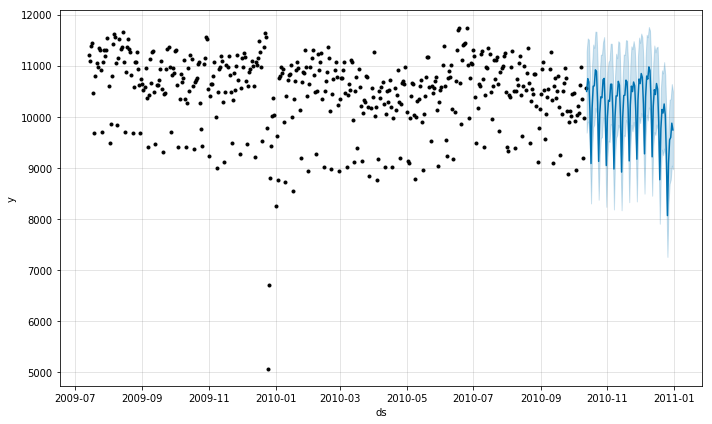

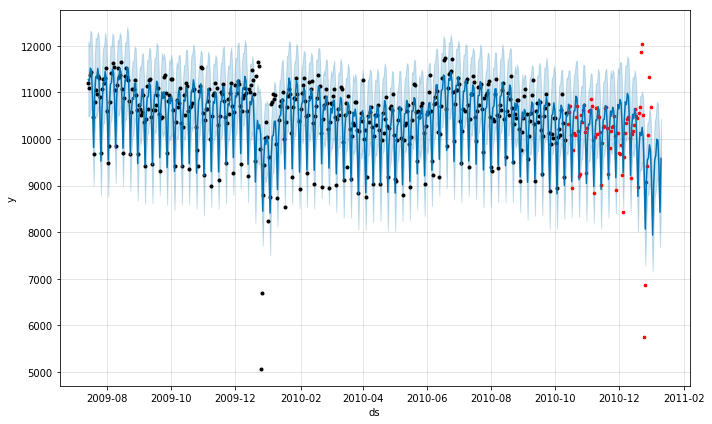

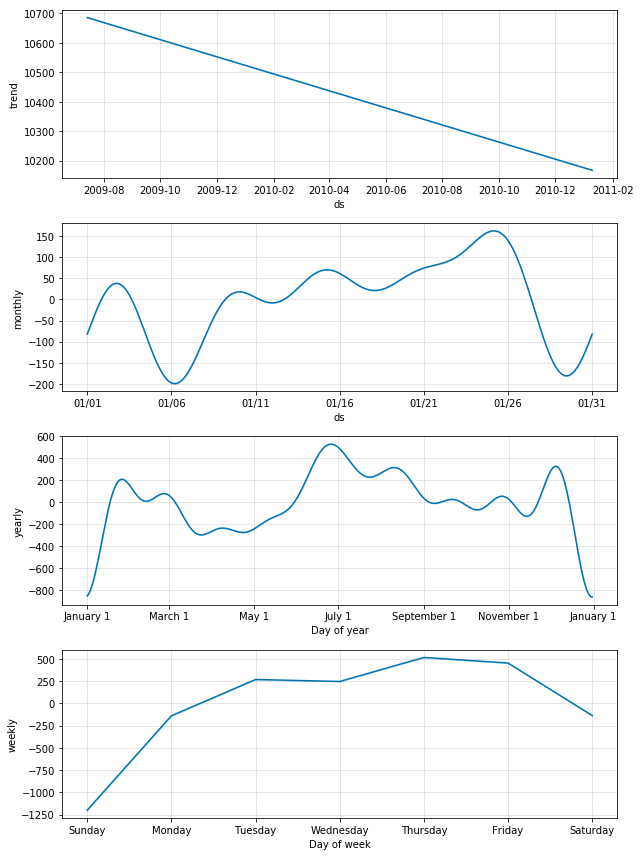

In [48]:
timeseriesPredictFbProphet(train2,test2)

### Cluster 3 Prediction of last 80 days Total daily consumption of cluster  and forecasting for 3 month ahead ##



In [49]:
# This is to make last 80 days as test dataset and rest as train dataset 
size = len(dfCluster3) - 80
train3, test3 = dfCluster3[0:size], dfCluster3[size:]

RMSE = 1854.94
Mean Absolute Error: -594.3 degrees.


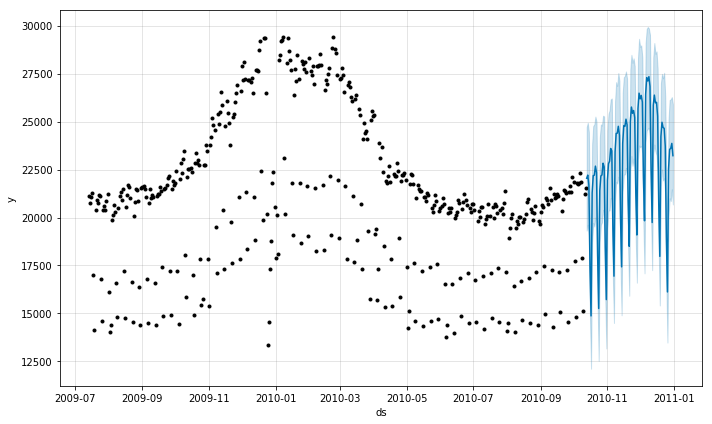

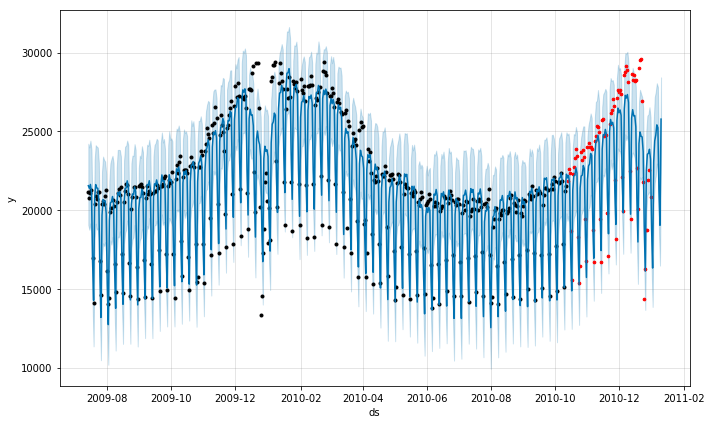

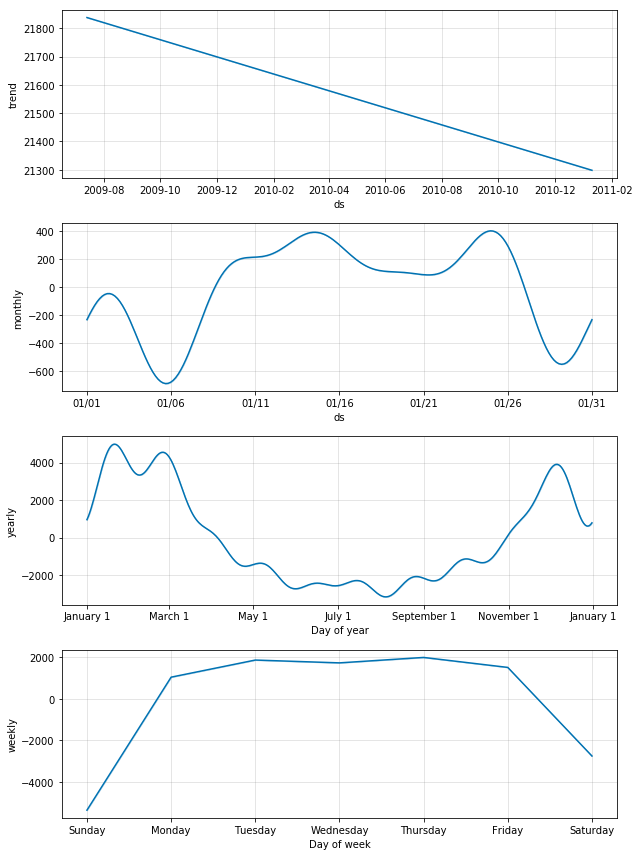

In [50]:
timeseriesPredictFbProphet(train3,test3)

### Cluster 4 Prediction of last 80 days Total daily consumption of cluster  and forecasting for 3 month ahead ##

In [51]:
# This is to make last 80 days as test dataset and rest as train dataset 
size = len(dfCluster4) - 80
train4, test4 = dfCluster4[0:size], dfCluster4[size:]

RMSE = 2016.41
Mean Absolute Error: -533.4 degrees.


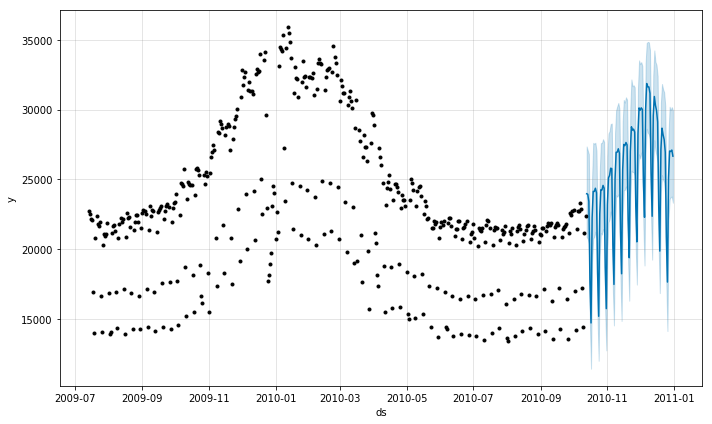

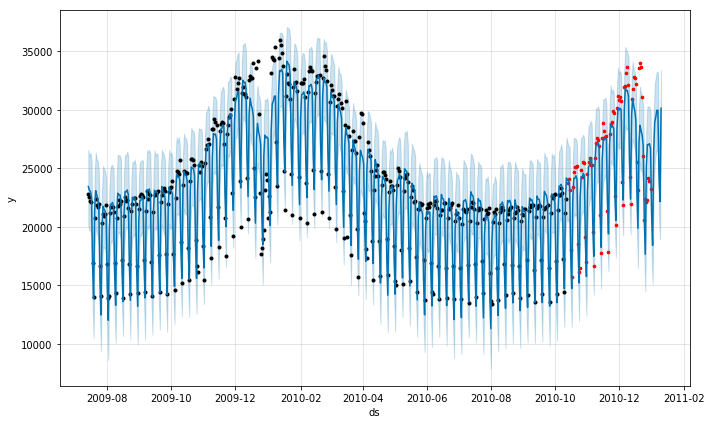

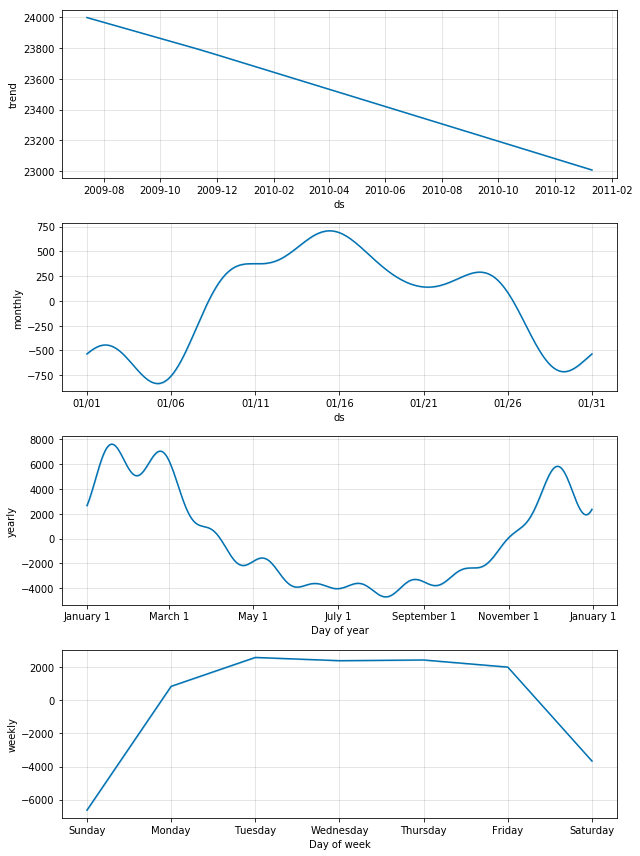

In [52]:
timeseriesPredictFbProphet(train4,test4)

### Cluster 5 Prediction of last 80 days Total daily consumption of cluster  and forecasting for 3 month ahead ##

In [53]:
# This is to make last 80 days as test dataset and rest as train dataset 
size = len(dfCluster5) - 80
train5, test5 = dfCluster5[0:size], dfCluster5[size:]

RMSE = 5681.84
Mean Absolute Error: -1525.61 degrees.


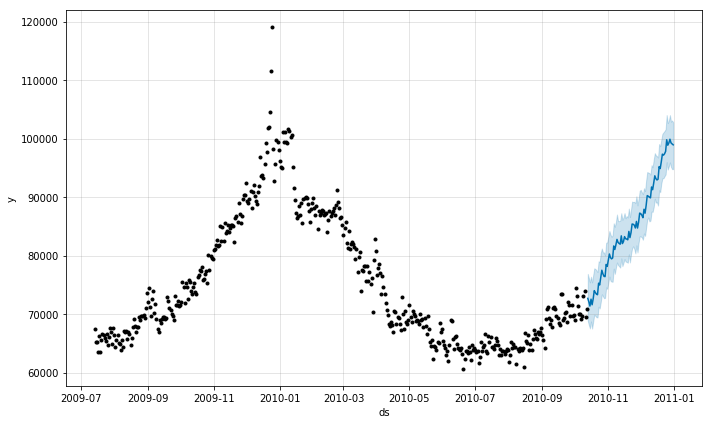

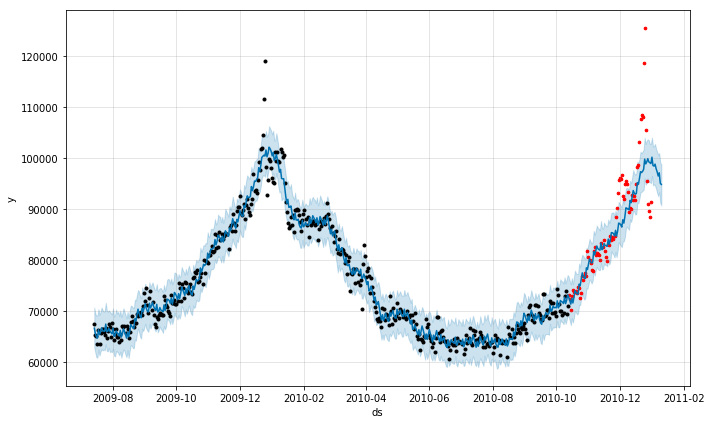

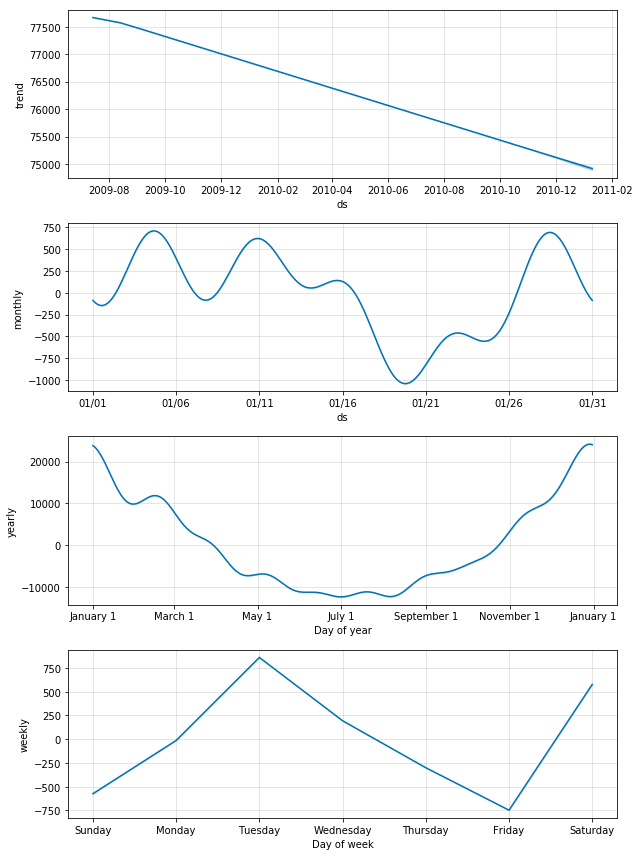

In [55]:
timeseriesPredictFbProphet(train5,test5)

#### Apart from the above we have tried to alsp predict each users daily consumption for last 80 days inside a cluster and forecasting of 90 days ahead. Below is the example for Cluster 2  and Cluster 3 for the same ##

In [56]:
# This is to make last 80 days as test dataset and rest as train dataset 
size = len(dfUserGroupClus2) - 80
train2, test2 = dfUserGroupClus2[0:size], dfUserGroupClus2[size:]

RMSE = 144.02
Mean Absolute Error: 130.24 degrees.


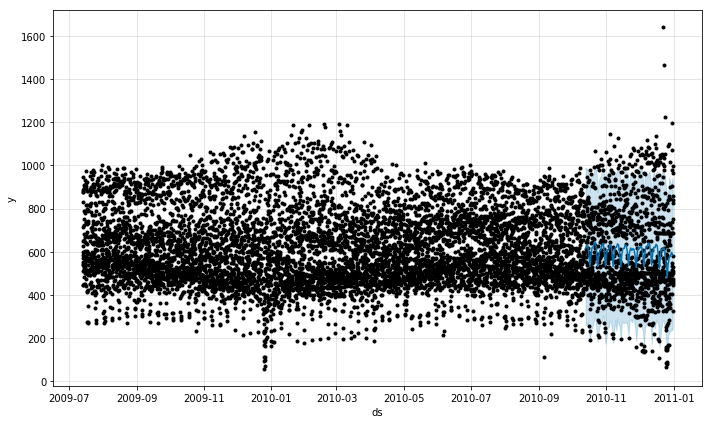

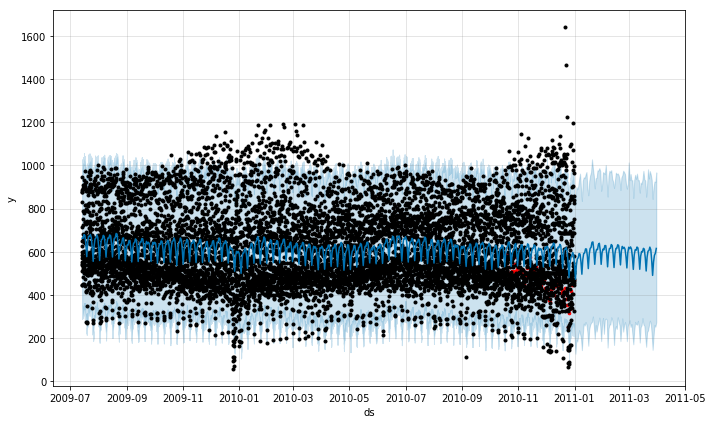

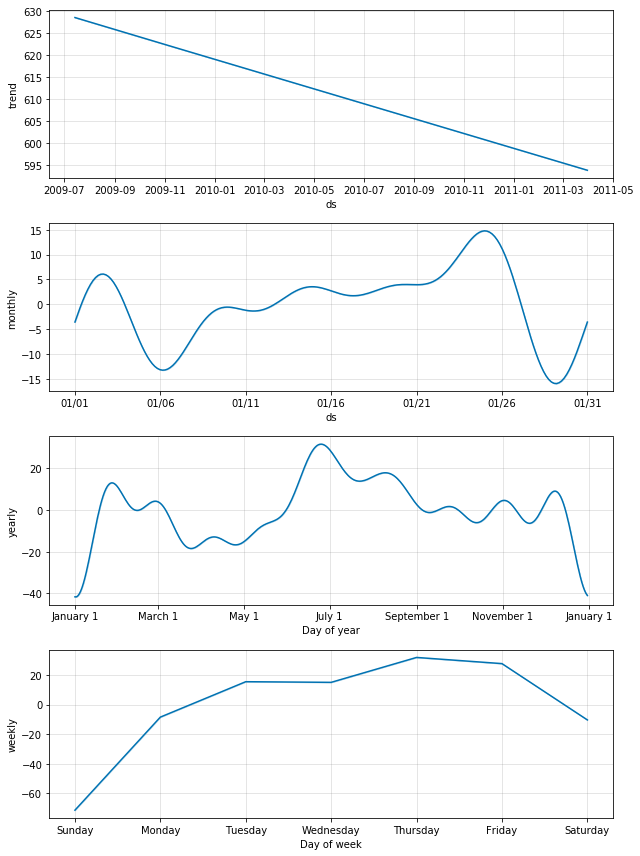

In [57]:
timeseriesPredictFbProphet(train2,test2)

In [58]:
# This is to make last 80 days as test dataset and rest as train dataset 
size = len(dfUserGroupClus3) - 80
train3, test3 = dfUserGroupClus3[0:size], dfUserGroupClus3[size:]

RMSE = 96.03
Mean Absolute Error: 3.44 degrees.


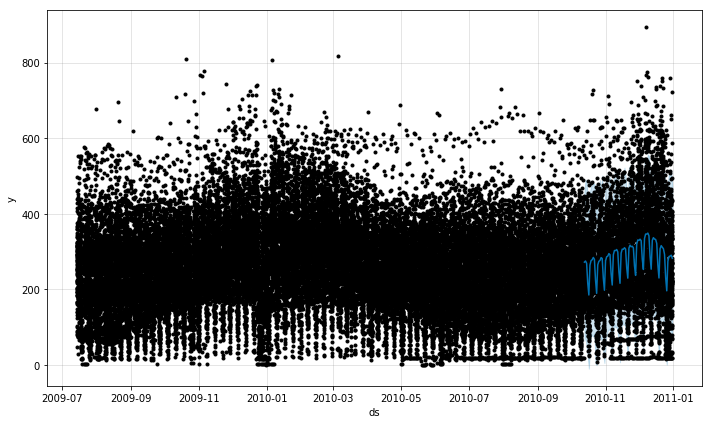

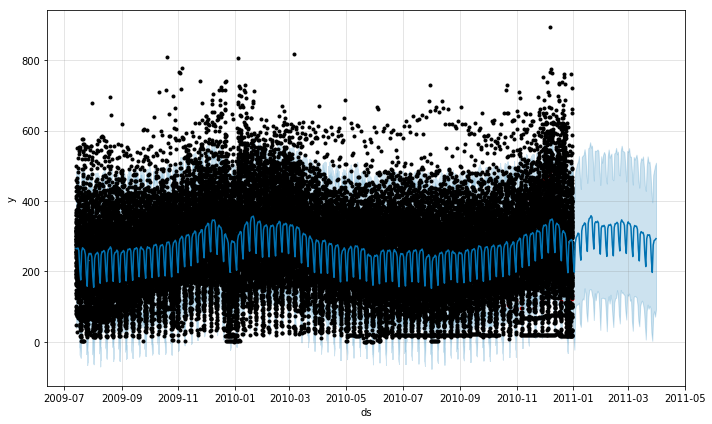

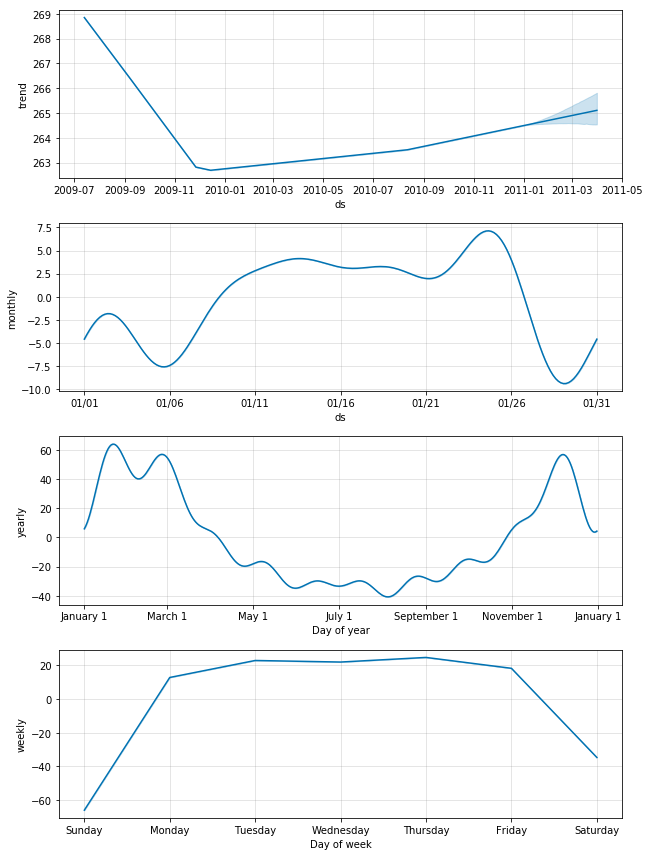

In [59]:
timeseriesPredictFbProphet(train3,test3)

## Random Forest Regressor Prediction ##

In [61]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from sklearn.metrics import mean_squared_error


In [65]:
def timeseriesPredictRFRegressor(train_X,train_y,test_X,test_y):
   # Instantiate model with 1000 decision trees
    rfmodel= RandomForestRegressor(n_estimators = 1000, random_state = 20)
    # Train the model on training data
    rfmodel.fit(train_X, train_y);
    # Use the Randomforest's predict method to predict
    predictions = rfmodel.predict(test_X)
    # Print out the Root mean squared error (RMSE)
    rmse = sqrt(mean_squared_error(test_y, predictions))
    print('Test RMSE: %.3f' % rmse)
    
    # Print out the mean absolute error (mae)
    errors = abs(predictions)- abs(test_y)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
    
    
    plt.xlabel('daytime')
    plt.ylabel('KW Usage')
    plt.plot(test_y, color='black')
    plt.plot(predictions, color='red')
    plt.show()


## Cluster 1 ##

In [80]:
size = len(dfUserGroupClus1) - 80
train1, test1 = dfUserGroupClus1[0:size], dfUserGroupClus1[size:]

#test_Y is the value we want to predict and train_y is the value we will use to train
train_y = np.array(train1['y'])
test_y = np.array(test1['y'])

#trainX and testX are the training and testing dataset 
train1= train1.drop('y', axis = 1)
train_X = np.array(train1)
test1= test1.drop('y', axis = 1)
test_X = np.array(test1)

### This takes too long to run ###

In [ ]:
# timeseriesPredictRFRegressor(train_X,train_y,test_X,test_y)

## Cluster 2 ##

In [68]:
size = len(dfUserGroupClus2) - 80
train2, test2 = dfUserGroupClus2[0:size], dfUserGroupClus2[size:]

#test_Y is the value we want to predict and train_y is the value we will use to train
train_y = np.array(train2['y'])
test_y = np.array(test2['y'])

#trainX and testX are the training and testing dataset 
train2= train2.drop('y', axis = 1)
train_X = np.array(train2)
test2= test2.drop('y', axis = 1)
test_X = np.array(test2)

Test RMSE: 146.405
Mean Absolute Error: 130.69 degrees.


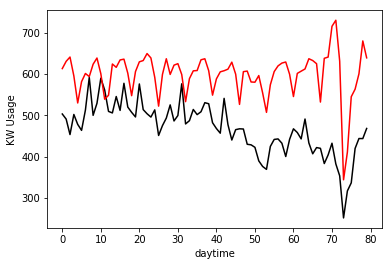

In [69]:
timeseriesPredictRFRegressor(train_X,train_y,test_X,test_y)

### Cluster 3 ###

In [70]:
size = len(dfUserGroupClus3) - 80
train3, test3 = dfUserGroupClus3[0:size], dfUserGroupClus3[size:]

#test_Y is the value we want to predict and train_y is the value we will use to train
train_y = np.array(train3['y'])
test_y = np.array(test3['y'])

#trainX and testX are the training and testing dataset 
train3= train3.drop('y', axis = 1)
train_X = np.array(train3)
test3= test3.drop('y', axis = 1)
test_X = np.array(test3)

Test RMSE: 85.171
Mean Absolute Error: 4.08 degrees.


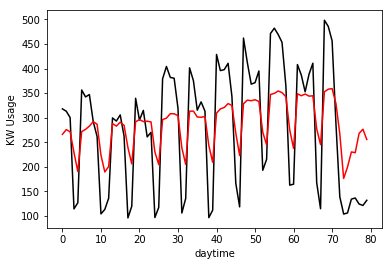

In [71]:
timeseriesPredictRFRegressor(train_X,train_y,test_X,test_y)

## Cluster 4 ##

In [72]:
size = len(dfUserGroupClus4) - 80
train4, test4 = dfUserGroupClus4[0:size], dfUserGroupClus4[size:]

#test_Y is the value we want to predict and train_y is the value we will use to train
train_y = np.array(train4['y'])
test_y = np.array(test4['y'])

#trainX and testX are the training and testing dataset 
train4= train4.drop('y', axis = 1)
train_X = np.array(train4)
test4= test4.drop('y', axis = 1)
test_X = np.array(test4)

Test RMSE: 67.368
Mean Absolute Error: 38.96 degrees.


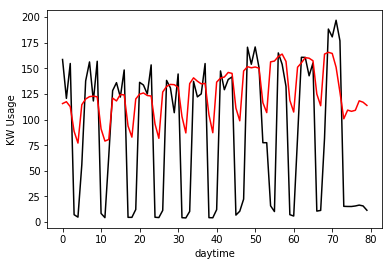

In [73]:
timeseriesPredictRFRegressor(train_X,train_y,test_X,test_y)

## Cluster 5 ##

In [78]:
size = len(dfUserGroupClus5) - 80
train5, test5 = dfUserGroupClus5[0:size], dfUserGroupClus5[size:]

#test_Y is the value we want to predict and train_y is the value we will use to train
train_y = np.array(train5['y'])
test_y = np.array(test5['y'])

#trainX and testX are the training and testing dataset 
train5= train5.drop('y', axis = 1)
train_X = np.array(train5)
test5= test5.drop('y', axis = 1)
test_X = np.array(test5)

Test RMSE: 6.385
Mean Absolute Error: 3.3 degrees.


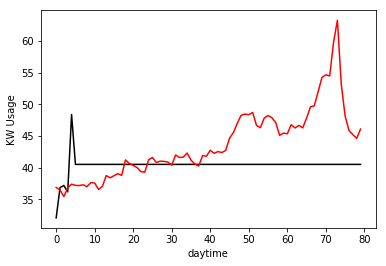

In [79]:
timeseriesPredictRFRegressor(train_X,train_y,test_X,test_y)